In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import  train_test_split 
from sklearn.neighbors import KNeighborsClassifier as knc


In [4]:
# to understand the images better we will be extracting the hog features from the images
# the gradient space makes the images much different compared to the image space
# Function to compute hog features

def hog(img):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[0], block_size[1], nbins) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
    
    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

In [5]:
# function to compute hog features
def compute_hog(pictures):
    hogs_temp = []
    #calculate hog for each image
    max_len = 0
    avg = 0
    for image in pictures:
        #the classifier takes 2d training data. hog produces 3d so we flatten the result to make it 1d.. then we
        #group all hogs in one list to make a 2d list

        # [REVEIW] resize because knn expects all data to be symetric

        grad = hog(cv2.resize(image, (50, 50), interpolation=cv2.INTER_AREA)).flatten()
    #     grad = hog(image).flatten()
        avg += len(grad)
        if len(grad) > max_len:
            max_len = len(grad)
        hogs_temp.append(grad)

    #convert the HoGs array to np array to be processed
    hogs_temp = np.array(hogs_temp)
    
    hogs = hogs_temp
    print('Shape of the hogs list: ',hogs.shape, max_len)
    return hogs

In [6]:
def train_classifier(hog_list, label_list):
    X_train, X_test, y_train, y_test = train_test_split(hog_list, label_list, test_size=0.25)

    lin_clf = svm.LinearSVC()

    lin_clf.fit(X_train, y_train)

    p_svm = lin_clf.predict(X_test)

    # Accuracy
    k = 0
    for x in range(len(p_svm)):
        if p_svm[x] == y_test[x]:
            k += 1
    print('Accuracy of SVM is', k, 'out of', len(X_test), ', percentage: %', 100*k/len(X_test))
    
    return lin_clf

In [7]:
def detection(hog_list):
    pred_back=[]
    p= np.array(bkg_classifer.predict(hog_list)) 
    pred=0
    for i in range(len(p)):
        
        if p[i] != 'background':
            pred= i
            pred_back.append(pred)
            
            
            
    pred_back= np.array(pred_back)
    return pred_back

In [8]:
def kmean(datas,k):
    data= np.float32(datas)
# before calling openCV's kmeans, we need to specify the stop criteria
# stop when either 100 iterations or an accuracy of 1 is reached
# define criteria = (type, max_iter=100, epsilon=1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1.0)

# set number of clusters
    K = k

# apply Kmeans
# cv2.kmeans(data, K, bestLabels, criteria, attempts, flags[, centers]) → retval, bestLabels, centers
# compactness: the sum of squared distance from each point to their corresponding centers
# labels: the label array (each element marked '0', '1', '2', etc.)
# centers: array of centers of clusters
    compactness, labels, centers = cv2.kmeans(data, K, None, criteria, 100, flags=cv2.KMEANS_RANDOM_CENTERS)
    
    return centers

In [9]:
def s_window(image,k):
    hogs_new = []
    max_len = 0
    avg = 0
    coord=[]
    size=[20,50,100,200]
    for value in size:
        for x in range(0,image.shape[1],20):
            for y in range(0,image.shape[0],20):
                sub = cv2.resize(image[y:y+value, x:x+value], (100,100))
                c= [x,y, value]
                coord.append(c)
                gradi = hog(cv2.resize(sub, (50, 50), interpolation=cv2.INTER_AREA)).flatten()


    #     grad = hog(image).flatten()
                avg += len(gradi)
                if len(gradi) > max_len:
                      max_len = len(gradi)
                hogs_new.append(gradi)

    #convert the HoGs array to np array to be processed
    hogs_new = np.array(hogs_new)
    print('Hog features detected = ',len(hogs_new))
    # hogs = hogs_new

    d= detection(hogs_new)
    print('Number of windows selected from HoG list =', len(d))

    rect=[]
    b_rect=[]
    for value in d:
        cpoint= coord[value]
        rect.append(cpoint)
    rect= np.array(rect)
    for pt in rect:
            box= [pt[0],pt[1],pt[0]+pt[2]+50,pt[1]+pt[2]]
            b_rect.append(box)
    b_rect= np.array(b_rect)
    
    coordinate= kmean(b_rect,k)
    
    b=[]
    for pts in coordinate:
        box= [pts[0], pts[1], pts[2], pts[3]]
        print('Box found with coordinate= ', box )
        b.append(box)
    b= np.array(b)
    
    return b, b_rect

In [200]:
def plot_boxes(image, coordinates):
    im_copy= image.copy()
    for pts in coordinates:
        boxes= cv2.rectangle(im_copy, (pts[0],pts[1]), (pts[2], pts[3]), (255,255,0), 5)
    boxes= cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.subplot(111), plt.imshow(boxes, )
    plt.title("Bounding Boxes"), plt.xticks([]), plt.yticks([])# Find distance between two boxes

def box_distance(box1, box2):
    # center of each box
    cx1, cy1 = box1[0] + (box1[2]-box1[0]/2), box1[1] + (box1[3]-box1[1]/2)
    cx2, cy2 = box2[0] + (box2[2]-box2[0]/2), box2[1] + (box2[3]-box2[1]/2)
    
    point = [[cx1-cx2 , cy1-cy2]]
    point1= [[cx1,cy1]]
    point2=[[cx2,cy2]]
    # distance between centers
    dist = dist= np.sqrt(((cx2-cx1)**2)+(cy2-cy1)**2)
    
    return dist
    
# Merge boxes that are at a certain threshold from the mean box
def merge_boxes(mean, boxes):
    # Threshold is height or width of the mean box, the longest of them
    threshold = int((max(mean[2]-mean[0], mean[3]-mean[1]))*2)
    close_boxes = []
    for box in boxes:
        d = box_distance(mean, box)
        if d < threshold:
            close_boxes.append(box)
    
    # Find the smallest upper left corner and largest lower right corner
    upper_lefts = np.array(close_boxes)[:,:2]
    lower_rights = np.array(close_boxes)[:,2:4]

    UL = upper_lefts.min(axis = 0) #min upper left
    LR = lower_rights.max(axis = 0) #max lower right
    
    merged = [UL[0], UL[1], LR[0], LR[1]]
    
    return merged
def final_boxes(listt):
    final_box = []
    for h in listt:
        m = merge_boxes(h, listt)
        final_box.append(m)
    final_box= np.array(final_box)
return final_box

SyntaxError: 'return' outside function (<ipython-input-200-eeafcb966325>, line 49)

In [11]:
# This will train a classifier to recorgnize backgroud images from foreground
# Only two classes are used here, positives and negative, positives are
# foreground images while negatives are background images. 

# Read ground truth values for all 500k images
ground_truth = np.genfromtxt('gt_train.csv', delimiter=',', dtype=['u4', 'U50'])

# Put image titles and their labels in a dictionary for easy retrieval
# Format: [imageNumber:Label]. Ex: [43123:'pedestrian']

gt = {}
for img in ground_truth:
    gt[img[0]] = img[1]
    

# Load 1000 grey images from each catagory and put them in the lists below
images = []
names = []
labels = []
for f in sorted(glob.glob("MIO-TCD-Classification/abc/*")):
    s=0
    for g in sorted(glob.glob(str(f)+'/*.jpg')):
        img = cv2.imread(g, 0) # Read image in grey
        name = int(g[-12:-4]) # File name
        images.append(img)
        names.append(name)
        labels.append(gt[name])
        
print(len(images), 'images were read with their names and labels')

h_list= compute_hog(images)

11181 images were read with their names and labels
Shape of the hogs list:  (11181, 1152) 1152


In [12]:
bkg_classifer= train_classifier(h_list,labels)

Accuracy of SVM is 2515 out of 2796 , percentage: % 89.94992846924177


Hog features detected =  3456
Number of windows selected from HoG list = 89
Box found with coordinate=  [221.42859, 103.571434, 378.57144, 210.7143]
Box found with coordinate=  [105.71429, 340.0, 232.85715, 417.14288]
Box found with coordinate=  [399.14893, 134.04254, 598.7234, 283.617]


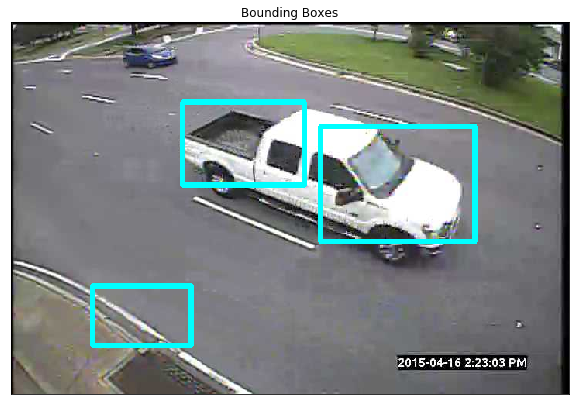

In [196]:
bounding_boxes= plot_boxes(img,hog)


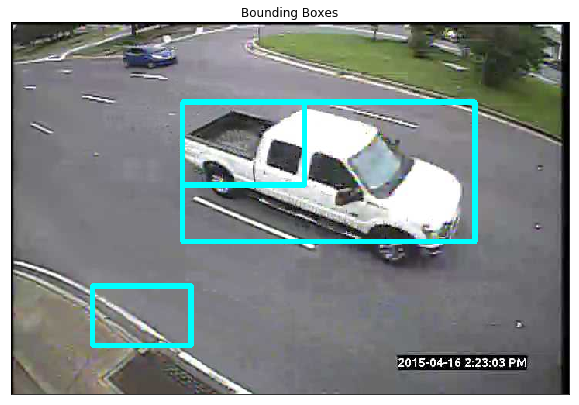

In [197]:
final_boxes = []
for h in hog:
    m = merge_boxes(h, hog)
    final_boxes.append(m)
plot_boxes(img, final_boxes)


[[221.42859, 103.571434, 378.57144, 210.7143], [105.71429, 340.0, 232.85715, 417.14288], [221.42859, 103.571434, 598.7234, 283.617]]
3


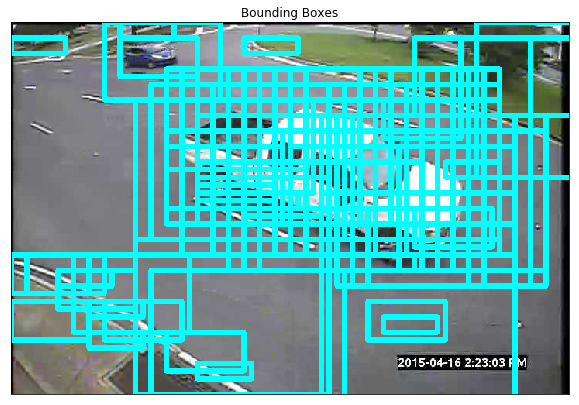

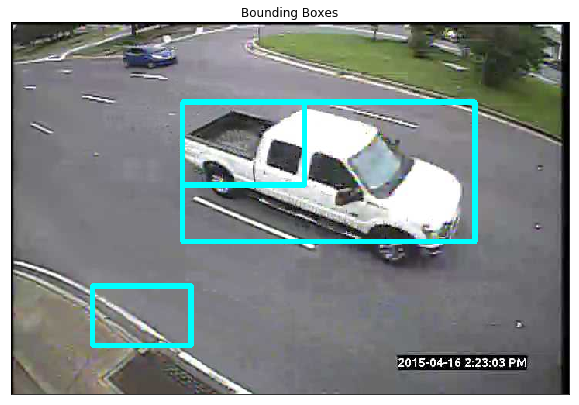

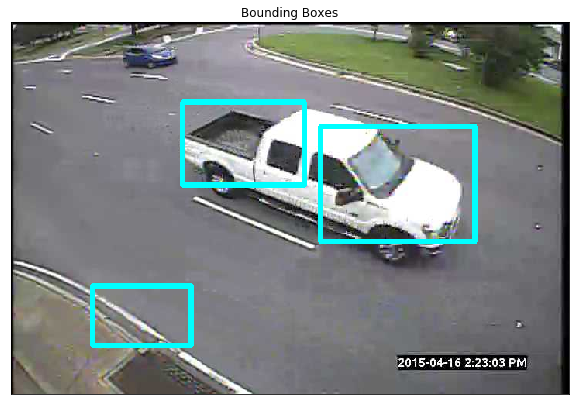